In [17]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from FinancialMachineLearning.data_loader.tickers import WikipediaStockListing

tickers = WikipediaStockListing()
sp100_tickers = tickers.sp100()['Symbol'].tolist()

In [18]:
data = yf.download(
    sp100_tickers,
    start = '2020-01-01',
    progress = False,
    auto_adjust = True,
    interval = '1d'
)

In [19]:
ret = data['Close'].pct_change().iloc[1:]

In [20]:
ret.head()

Ticker,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,-0.009722,-0.009492,-0.012191,-0.001666,-0.007834,-0.007728,-0.010183,-0.006789,0.000482,-0.012139,...,-0.013275,-0.010120,-0.007078,-0.000599,-0.011655,-0.007953,-0.010647,-0.006139,-0.008828,-0.008039
2020-01-06,0.007968,0.007892,0.005239,-0.006530,0.005726,0.000779,-0.004321,0.007674,-0.000263,0.014886,...,-0.006961,0.006942,-0.008565,-0.004455,-0.013673,-0.002162,-0.002152,-0.005990,-0.002036,0.007678
2020-01-07,-0.004703,-0.005705,-0.005559,-0.021590,-0.000959,-0.005642,-0.002893,-0.009405,-0.021308,0.002092,...,0.019298,-0.006036,-0.007579,-0.001721,-0.009530,-0.002643,-0.011117,-0.008286,-0.009265,-0.008184
2020-01-08,0.016086,0.007087,0.004076,0.001962,0.013438,0.011740,-0.008705,0.000756,0.008673,-0.007809,...,0.002704,0.021084,0.010951,0.005690,-0.002099,0.017118,0.001846,0.003039,-0.003432,-0.015080
2020-01-09,0.021241,0.007708,0.002668,0.008907,0.007636,0.011023,0.023834,0.002981,0.003767,0.004799,...,0.012099,-0.005678,-0.005111,0.002314,0.000351,0.006930,-0.004146,-0.001704,0.010331,0.007655


### Mutual Information

Mutual Information은 $Y$값을 알 때 초래되는 $X$의 불확실성 감소로 정의된다. 

$$
\begin{align}
I(X,Y) &= H(X) - H(X|Y) \\
       &= H(X) + H(Y) - H(X, Y) \\
       &= \sum_{x \in S_X} \sum_{y \in S_Y} p(x,y)\log \left( \frac{p(x,y)}{p(x)p(y)}\right) \\
       &= D_{KL}\left[ p(x,y) \Vert p(x)p(y)\right] = \sum_{y \in S_Y} p(y) \sum_{x \in S_X} p(x|y) \log \left( \frac{p(x|y)}{p(x)}\right) \\
       &= E_Y \left[ D_{KL}\left[ p(x|y) \Vert p(x)\right] \right] = \sum_{x \in S_X} p(x) \sum_{y \in S_Y} p(x|y) \log \left( \frac{p(y|x)}{p(y)}\right) \\
       &= E_X \left[ D_{KL}\left[ p(y|x) \Vert p(y)\right] \right]
\end{align}
$$

위에서 $I(X,Y) \geq 0, I(X,Y) = I(Y,X)$이고, $I(X, X) = H(X)$임을 알 수 있다. $X$와 $Y$가 독립일 때 $p(x, y) = p(x)p(y)$이므로 $I(X, Y) = 0$이다. 상계는 $I(X, Y) \leq \min \{H(X), H(Y)\}$로 주어진다. 그러나 상호 정보는 거리 척도가 아니다. 왜냐하면 이는 삼각 부등식 $I(X,Z) \nleq I(X,Y) + I(Y, Z)$을 성립하지 못하기 때문이다. 상호 정보의 중요한 속성은 다음의 그룹화 특성이다.

$$I(X, Y, Z) = I(X, Y) + I\left[(X, Y), Z\right]$$

여기서 $(X, Y)$는 $X$와 $Y$의 결합 분포를 나타낸다. $X, Y$와 $Z$는 그 자체로 결합 분포를 나타낼 수 있기 때문에 위의 특성은 상호 정보를 더 단순한 구성 요소로 분해하는 데 사용할 수 있다. 이는 상호 정보를 응집형 군집화 알고리즘과 전방 특성 선택의 맥락에서 유용한 유사도 척도로 만든다.

차원당 일정 수의 분할을 가진 정규화된 그리드로 이산화된 동일 크기의 2개의 배열 $x$와 $y$가 주어졌을 때 아래의 코드는 한계 엔트로피, 결합 엔트로피, 조건부 엔트로피와 상호 정보를 계산하는 법을 보여준다.

In [21]:
from FinancialMachineLearning.metrics.distance import DistanceDataFrame

dist = DistanceDataFrame(ret.dropna())

In [22]:
mutual_info = dist.mutual_information(norm = True)

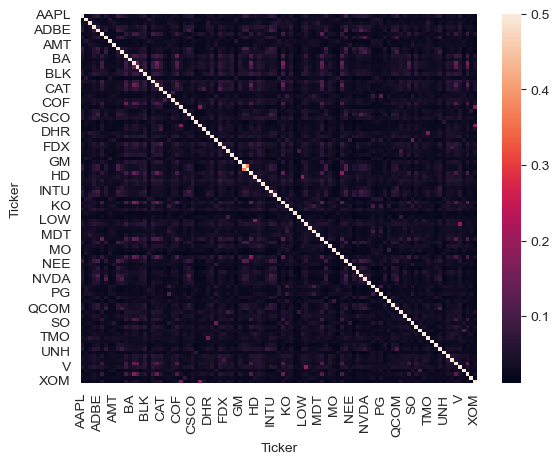

In [23]:
import seaborn as sns
sns.heatmap(mutual_info)
plt.show()

<Axes: xlabel='Ticker', ylabel='Ticker'>

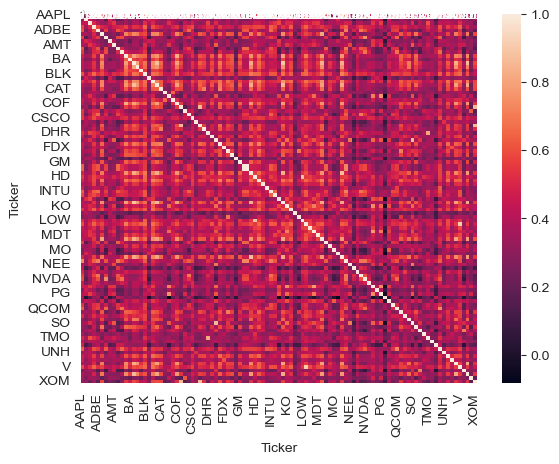

In [25]:
sns.heatmap(ret.corr(), annot=True)

### Variational Information

정보 변분은 다음과 같이 정의된다

$$
\begin{align}
VI(X,Y) &= H(X|Y) + H(Y|X) \\
    &= H(X) + H(Y) - 2I(X,Y) \\
    &= 2H(X,Y) - H(X) - H(Y) \\
    &= H(X, Y) - I(X, Y)
\end{align}
$$

이 척도는 다른 변수의 값을 들었을 때 다른 한 변수에서 예상하는 불확실성으로 해석할 수 있다. 이는 $VI(X, Y) = 0 \Leftrightarrow X = Y$와 같은 하계, $VI(X,Y) \leq H(X,Y)$와 같은 상계를 갖는다. 정보 변분은 거리 척도다. 왜냐하면 비음성, 대칭성, 삼각 부등식의 공리를 만족하기 때문이다.

$H(X, Y)$는 $S_X$와 $S_Y$의 크기의 함수이므로 $VI(X,Y)$는 엄격한 상계를 갖지 않는다. 우리는 여러 모집단 크기 간에 정보 변분을 비교하고자 하기 때문에 이것은 문제가 된다. 다음 식은 모든 $(X,y)$쌍에 대해 0과 1 사이로 한정되는 척도다

$$\tilde{VI}(X,Y) = \frac{VI(X,Y)}{H(X,Y)} = 1 - \frac{I(X,Y)}{H(X,Y)}$$

Kraskov(2008)을 따라서 더 강한 대안의 한정된 척도는 다음과 같다.

$$\tilde{\tilde{VI}}(X,Y) = \frac{\max\{H(X|Y), H(Y|X)\}}{\max\{H(X), H(Y)\}} = 1 - \frac{I(X,Y)}{\max\{H(X), H(Y)\}}$$

여기서 모든 $(X,y)$쌍에 대해 $\tilde{\tilde{VI}}(X,Y) \leq \tilde{VI}(X,Y)$이다. 이전의 예저를 따라서 아래 코드는 정보 변분을 계산한다.

In [28]:
variational_info = dist.variational_information(norm = False)

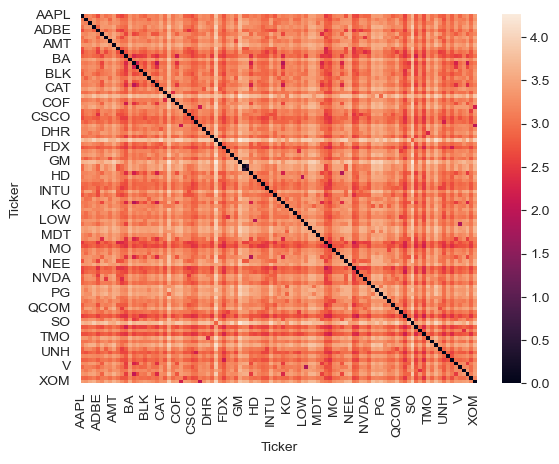

In [29]:
import seaborn as sns
sns.heatmap(variational_info)
plt.show()

### Discretization

이제까지 랜덤 변수가 이산 변수라고 가정했다. 연속인 경우 값을 양자화하고, 동일한 개념을 구간으로 나눠진 관찰에 적용한다. 확률 분포 함수 $f_X[X]$를 가진 연속 랜덤 변수 $X$를 고려하자. Shannon은 이것의 엔트로피를 다음과 같이 정의했다. 

$$H[X] = - \int_{-\infty}^{\infty} f_X[x] \log \left[f_X[x]\right]dx$$

Gaussian Random Variable $X$의 Entropy는 $H[X] = \frac{1}{2 \log[2\pi e \sigma^2]}$이므로 표준 정규분포의 경우 $H[X] \approx 1.42$이다. 유한 실수값 샘플에서 $H[X]$를 추정하는 한 방법은 관측값 $\{x\}$를 걸친 범위를 동일한 크기 $\Delta_X, \Delta_X = \frac{\left( \max\{x\} - \min\{x\}\right)}{B_X}$의 $B_X$개의 binary로 나누는 것이다. 이는 다음을 산출한다.

$$H[X] \approx -\sum_{i=1}^{B_X} f_X[x_i] \log\left[ f_X[x_i]\right]\Delta_X$$

동일한 논의를 적용하면 결합 엔트로피는 다음과 같다

$$\hat{H}[X,Y] = - \sum_{i=1}^{B_X} \sum_{j=1}^{B_Y} \frac{N_{i,j}}{N} \log \left[ \frac{N_{i,j}}{N}\right] + \log \left[ \Delta_X \Delta_Y\right]$$

추정량 $\hat{H}[X]$와 $\hat{H}[X,Y]$로부터 조건부 엔트로피, 상호 정보와 정보 변분의 추정량을 도출할 수 있다. 이들 식으로부터 알 수 있듯이, 결과는 $B_X$와 $B_Y$의 선택에 의해 편향될 수 있다. 한계 엔트로피의 경우 Hacine-Gharbi(2012)는 다음과 같이 optimal binning이 주어지는 것을 밝혔다.

$$\begin{align}
B_X =& \text{round}\left[ 
\frac{\zeta}{6} + \frac{2}{3\zeta} + \frac{1}{3}
\right] \\
\zeta =& \sqrt[3]{8 + 324N + 12\sqrt{36N + 729N^2}}
\end{align}$$

결합 엔트로피의 경우는 Hacine-Gharbi와 Ravier(2018)가 optimal binning이 다음에 의해 주어진다는 것을 발견했다.

$$
B_X = B_Y = \text{round}\left[ \frac{1}{\sqrt{2}} \sqrt{1 + \sqrt{1 + \frac{24N}{1 - \hat{p}^2}}}\right]
$$

여기서 $\hat{p}$는 $X$와 $Y$의 상관계수 추정치이다.